## CEFR Audio Classification

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import warnings

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydub import AudioSegment
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from xgboost import XGBClassifier

warnings.filterwarnings("ignore", category=UserWarning, module="librosa")
np.random.seed(42)

In [3]:
from typing import Dict, List, Tuple


def normalize_signal(signal: np.ndarray) -> np.ndarray:
    mean = np.mean(signal)
    std = np.std(signal)
    if std == 0:
        return signal - mean
    return (signal - mean) / std


def trim_audio(signal: np.ndarray, sample_rate: int, top_db: float = 20, frame_length: int = 512, hop_length: int = 128) -> np.ndarray:
    try:
        trimmed, _ = librosa.effects.trim(
            signal,
            top_db=top_db,
            frame_length=frame_length,
            hop_length=hop_length,
        )
        if len(trimmed) == 0:
            return signal
        return trimmed
    except Exception:
        return signal


def load_audio(file_path: Path, target_sr: int = 16000) -> Tuple[np.ndarray, int]:
    try:
        signal, sr = librosa.load(str(file_path), sr=None, mono=True)
    except Exception:
        audio = AudioSegment.from_file(str(file_path))
        temp_path = file_path.with_suffix(".tmp.wav")
        audio.export(temp_path, format="wav")
        signal, sr = librosa.load(str(temp_path), sr=None, mono=True)
        temp_path.unlink(missing_ok=True)
    if sr != target_sr:
        signal = librosa.resample(signal, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    return signal, sr


def _pad_or_trim(signal: np.ndarray, target_length: int) -> np.ndarray:
    if len(signal) > target_length:
        return signal[:target_length]
    if len(signal) < target_length:
        return np.pad(signal, (0, target_length - len(signal)))
    return signal


def chunk_signal(signal: np.ndarray, sample_rate: int, clip_duration: float) -> List[Tuple[np.ndarray, int, float, float]]:
    if clip_duration <= 0:
        raise ValueError("clip_duration must be positive")
    target_length = int(sample_rate * clip_duration)
    if target_length <= 0:
        raise ValueError("clip_duration too small for the given sample rate")

    total_samples = len(signal)
    num_chunks = int(np.ceil(total_samples / target_length))
    chunks: List[Tuple[np.ndarray, int, float, float]] = []
    for idx in range(num_chunks):
        start = idx * target_length
        end = min(start + target_length, total_samples)
        chunk = signal[start:end]
        if len(chunk) == 0:
            continue
        chunk = _pad_or_trim(chunk, target_length)
        chunks.append((chunk, idx, start / sample_rate, end / sample_rate))
    return chunks


def _summary_stats(matrix: np.ndarray, prefix: str) -> Dict[str, float]:
    if matrix.ndim == 1:
        matrix = matrix[np.newaxis, :]
    stats: Dict[str, float] = {}
    for idx, row in enumerate(matrix):
        stats[f"{prefix}_{idx}_mean"] = float(np.mean(row))
        stats[f"{prefix}_{idx}_std"] = float(np.std(row))
    return stats


def _compute_features_from_signal(signal: np.ndarray, sample_rate: int) -> Dict[str, float]:
    features: Dict[str, float] = {
        "duration_sec": float(len(signal) / sample_rate),
        "rms_energy": float(np.sqrt(np.mean(signal ** 2))),
    }

    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=20)
    features.update(_summary_stats(mfcc, "mfcc"))
    delta = librosa.feature.delta(mfcc)
    features.update(_summary_stats(delta, "delta_mfcc"))
    delta2 = librosa.feature.delta(mfcc, order=2)
    features.update(_summary_stats(delta2, "delta2_mfcc"))

    rmse = librosa.feature.rms(y=signal)
    features.update(_summary_stats(rmse, "rmse"))
    zcr = librosa.feature.zero_crossing_rate(y=signal)
    features.update(_summary_stats(zcr, "zcr"))
    centroid = librosa.feature.spectral_centroid(y=signal, sr=sample_rate)
    features.update(_summary_stats(centroid, "centroid"))
    bandwidth = librosa.feature.spectral_bandwidth(y=signal, sr=sample_rate)
    features.update(_summary_stats(bandwidth, "bandwidth"))
    rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sample_rate)
    features.update(_summary_stats(rolloff, "rolloff"))
    contrast = librosa.feature.spectral_contrast(y=signal, sr=sample_rate)
    features.update(_summary_stats(contrast, "contrast"))
    tonnetz = librosa.feature.tonnetz(y=signal, sr=sample_rate)
    features.update(_summary_stats(tonnetz, "tonnetz"))

    return features


def extract_feature_vectors(
    file_path: Path,
    target_sr: int = 16000,
    clip_duration: float = 4.0,
    silence_threshold: float = 20,
) -> List[Dict[str, float]]:
    signal, sr = load_audio(file_path, target_sr=target_sr)
    signal = trim_audio(signal, sr, top_db=silence_threshold)
    signal = normalize_signal(signal)

    chunk_records: List[Dict[str, float]] = []
    for chunk, idx, start_sec, end_sec in chunk_signal(signal, sr, clip_duration):
        features = _compute_features_from_signal(chunk, sr)
        features.update(
            {
                "chunk_index": idx,
                "chunk_duration_sec": float(len(chunk) / sr),
                "clip_start_sec": float(start_sec),
                "clip_end_sec": float(end_sec),
                "clip_duration_sec": float(clip_duration),
            }
        )
        chunk_records.append(features)

    return chunk_records


In [ ]:
CLIP_SECONDS = 5.0  # control segment length
TARGET_SAMPLE_RATE = 16000
CACHE_NAME = f"cefr_features_{str(CLIP_SECONDS).replace('.', 'p')}s_{TARGET_SAMPLE_RATE}hz.pkl"
FEATURE_CACHE_PATH = Path.cwd() / CACHE_NAME

DATASET_ROOT = Path("..").resolve() / "dataset"
audio_records = []
errors = []

if FEATURE_CACHE_PATH.exists():
    print(f"Loading cached features from {FEATURE_CACHE_PATH}")
    feature_table = pd.read_pickle(FEATURE_CACHE_PATH)
else:
    audio_items = []
    for class_dir in sorted(DATASET_ROOT.iterdir()):
        if not class_dir.is_dir():
            continue
        for audio_path in sorted(class_dir.glob("*.mp3")):
            audio_items.append((class_dir.name, audio_path))

    for label, audio_path in tqdm(audio_items, desc="Extracting features"):
        try:
            chunk_features = extract_feature_vectors(
                audio_path,
                target_sr=TARGET_SAMPLE_RATE,
                clip_duration=CLIP_SECONDS,
            )
            if not chunk_features:
                errors.append((audio_path, "No audio content after preprocessing"))
                continue
            for features in chunk_features:
                features["label"] = label
                features["file_path"] = str(audio_path)
                audio_records.append(features)
        except Exception as exc:
            errors.append((audio_path, str(exc)))

    feature_table = pd.DataFrame(audio_records)
    feature_table.to_pickle(FEATURE_CACHE_PATH)
    print(f"Saved feature table to {FEATURE_CACHE_PATH}")

feature_table.head()

Extracting features: 100%|██████████| 35/35 [00:41<00:00,  1.17s/it]

Saved feature table to /home/arvin/Projects/welsh-test/notebooks/cefr_features_5p0s_16000hz.pkl


,duration_sec,rms_energy,mfcc_0_mean,mfcc_0_std,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,...,tonnetz_4_std,tonnetz_5_mean,tonnetz_5_std,chunk_index,chunk_duration_sec,clip_start_sec,clip_end_sec,clip_duration_sec,label,file_path
0,5.0,1.065615,126.308693,53.825397,74.477486,21.502382,18.531876,20.044294,28.421663,8.777952,...,0.054579,0.011069,0.038074,0,5.0,0.0,5.000,5.0,a1,/home/arvin/Projects/welsh-test/dataset/a1/Une...
1,5.0,1.210346,-9.921066,148.928040,60.101570,38.594437,-4.674208,31.359707,27.062874,32.740326,...,0.067736,-0.000917,0.037986,1,5.0,5.0,10.000,5.0,a1,/home/arvin/Projects/welsh-test/dataset/a1/Une...
2,5.0,0.741323,-33.640224,149.852036,78.600204,50.772671,-17.395176,32.074711,27.483212,31.328447,...,0.033727,-0.005603,0.028424,2,5.0,10.0,15.000,5.0,a1,/home/arvin/Projects/welsh-test/dataset/a1/Une...
3,5.0,0.480381,-239.022934,174.313599,23.995533,42.083855,-3.582081,21.526327,7.541358,19.118883,...,0.035945,0.004073,0.032350,3,5.0,15.0,16.904,5.0,a1,/home/arvin/Projects/welsh-test/dataset/a1/Une...
4,5.0,1.065615,126.308693,53.825397,74.477486,21.502382,18.531876,20.044294,28.421663,8.777952,...,0.054579,0.011069,0.038074,0,5.0,0.0,5.000,5.0,a1,/home/arvin/Projects/welsh-test/dataset/a1/Une...


In [5]:
unique_files = feature_table["file_path"].nunique()
print(
    f"Extracted {len(feature_table)} segments from {unique_files} files across {feature_table['label'].nunique()} classes"
)
if errors:
    print(f"Encountered {len(errors)} issues during extraction")
    for path, message in errors:
        print(f"  {path.name}: {message}")
feature_table["label"].value_counts()

Extracted 457 segments from 35 files across 4 classes


label
b2    123
a1    117
a2    116
b1    101
Name: count, dtype: int64

In [6]:
feature_table = feature_table.replace([np.inf, -np.inf], np.nan).fillna(0.0)
metadata_cols = [
    "label",
    "file_path",
    "chunk_index",
    "clip_start_sec",
    "clip_end_sec",
    "clip_duration_sec",
    "chunk_duration_sec",
]
X = feature_table.drop(columns=metadata_cols, errors="ignore").astype(np.float32)
y = feature_table["label"]

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded,
)

model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42,
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

          a1       0.79      0.92      0.85        24
          a2       0.94      0.70      0.80        23
          b1       0.94      0.80      0.86        20
          b2       0.83      1.00      0.91        25

    accuracy                           0.86        92
   macro avg       0.88      0.85      0.86        92
weighted avg       0.87      0.86      0.86        92



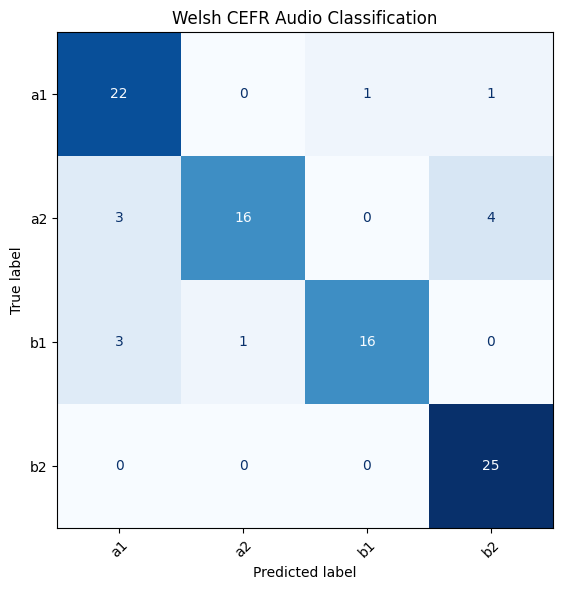

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=encoder.classes_,
    cmap="Blues",
    xticks_rotation=45,
    colorbar=False,
    ax=ax,
)
ax.set_title("Welsh CEFR Audio Classification")
plt.tight_layout()
plt.show()